In [1]:
# LSTM for OPEC
import quandl
quandl.ApiConfig.api_key="Mev5v8Rr-58sWDopyvgh"
mydata = quandl.get("OPEC/ORB-OPEC")
mydata.head(20)

,Value
Date,
2003-01-02,30.05
2003-01-03,30.83
2003-01-06,30.71
2003-01-07,29.72
2003-01-08,28.86
2003-01-09,29.51
2003-01-10,29.82
2003-01-13,29.82
2003-01-14,30.21


In [133]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
# tutorial:https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# tutorial:https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# load
values = mydata.values
values = values.astype('float32')
# normalize
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print(reframed.head())
# predicting next day open as var1(t)


   var1(t-1)   var1(t)
1   0.064017  0.070613
2   0.070613  0.069598
3   0.069598  0.061226
4   0.061226  0.053953
5   0.053953  0.059450


In [157]:
# split into train and tets
values = reframed.values
train_size = int(len(values) * 0.67)
test_size = len(values) - train_size
train, test = values[0:train_size,:], values[train_size:len(values),:]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2651, 1, 1) (2651,) (1307, 1, 1) (1307,)


Train on 2651 samples, validate on 1307 samples
Epoch 1/10
 - 4s - loss: 0.0861 - val_loss: 0.2514
Epoch 2/10
 - 1s - loss: 0.1316 - val_loss: 0.1749
Epoch 3/10
 - 1s - loss: 0.0771 - val_loss: 0.1026
Epoch 4/10
 - 1s - loss: 0.0348 - val_loss: 0.0448
Epoch 5/10
 - 1s - loss: 0.0151 - val_loss: 0.0158
Epoch 6/10
 - 1s - loss: 0.0106 - val_loss: 0.0078
Epoch 7/10
 - 1s - loss: 0.0097 - val_loss: 0.0082
Epoch 8/10
 - 1s - loss: 0.0094 - val_loss: 0.0084
Epoch 9/10
 - 1s - loss: 0.0093 - val_loss: 0.0081
Epoch 10/10
 - 1s - loss: 0.0092 - val_loss: 0.0078


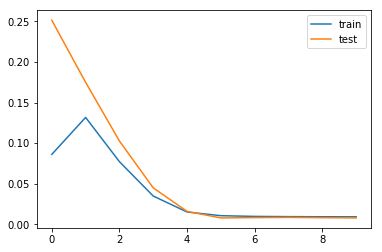

In [158]:
# LSTM network
model = Sequential()
model.add(LSTM(1, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=5, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [159]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE 
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.193


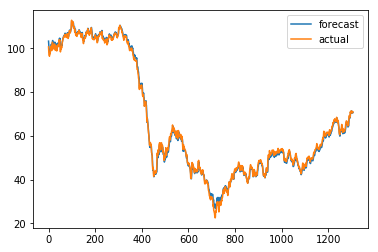

In [160]:
# plot for test
pyplot.plot(inv_yhat, label='forecast')
pyplot.plot(inv_y, label='actual')
pyplot.legend()
pyplot.show()